# import packages

# barplots of mean relative loss 

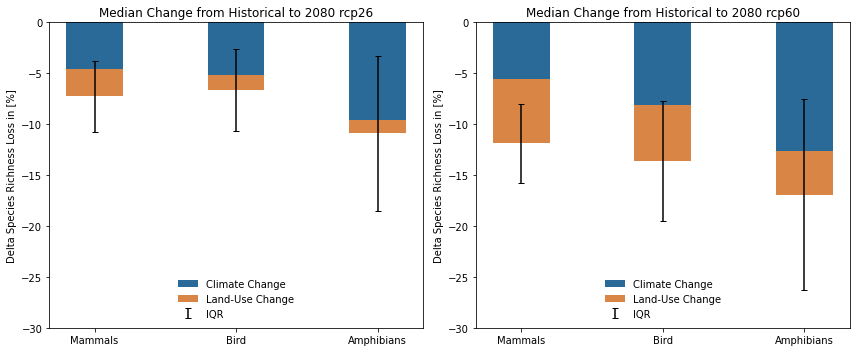

<Figure size 432x288 with 0 Axes>

In [93]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100 
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100 
                land_use_change = climate_land_change - climate_change

                climate_land_change_loss = climate_land_change.where(climate_land_change < 0)
                climate_change_loss = climate_change.where((climate_land_change < 0) & (climate_change < 0))
                
                                # Avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0
                climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)

                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where(climate_change < 0)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss
                mean_land_use_change[scenario][sdm][gcm][taxa] = land_use_change

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

       # mean_climate_change = np.median([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
       # mean_land_use_change2 = np.median([np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        #std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        
        
        climate_change_data = np.concatenate([mean_newvalue_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])
        land_use_change_data = np.concatenate([mean_sum_bin_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])

        # Calculate the median for the concatenated data
        mean_climate_change = np.nanmedian(climate_change_data)
        mean_land_use_change2 = np.nanmedian(land_use_change_data) -mean_climate_change
        
        Q1 = np.nanpercentile(climate_change_data, 25)
        Q3 = np.nanpercentile(climate_change_data, 75)
        iqr_climate_change = (Q3 - Q1)/2

        std_dev_climate_change = np.std([np.nanmedian(mean_newvalue_change[scenario][sdm][gcm][taxa].values)for sdm in sdms for gcm in gcms])


        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=iqr_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'IQR'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=iqr_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    ax.set_ylim(top=0, bottom=-30)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Delta Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Median Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

In [1]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_rev.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_rev.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_rev.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_rev.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100
                land_use_change = climate_land_change - climate_change

                climate_land_change_loss = climate_land_change.where(climate_land_change < 0)
                climate_change_loss = climate_change.where((climate_land_change < 0) & (climate_change < 0))
                
                                # Avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0
                climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)

                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where(climate_change < 0)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss
                mean_land_use_change[scenario][sdm][gcm][taxa] = land_use_change

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

        mean_climate_change = np.mean([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.mean([np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    #ax.set_ylim(top=0, bottom=-25)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Mean Change in Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

FileNotFoundError: [Errno 2] No such file or directory: "/storage/scratch/users/ch21o450/data/intermediate_results/newvalue_hist_sum_GAM_GFDL-ESM2M_Mammals_['rcp26']_['65']_rev.pkl"

In [13]:

regionlist = ['West, Central, East & South Africa']



    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')


In [ ]:
# relative loss in species richness sub-saharan africa
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100 
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100 
                land_use_change = climate_land_change - climate_change

                climate_land_change_loss = climate_land_change.where(climate_land_change < 0)
                climate_change_loss = climate_change.where((climate_land_change < 0) & (climate_change < 0))
                
                                # Avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0
                climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)

                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0).where(oceania_mask_renamed==1)
                climate_change_loss = climate_change.where(climate_change < 0).where(oceania_mask_renamed==1)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss

                
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

        mean_climate_change = np.mean([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.mean([np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    ax.set_ylim(top=0, bottom=-50)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Mean Change in Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')
fig.suptitle('West, Central, East & South Africa', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

NameError: name 'oceania_mask_renamed' is not defined

# barplots of mean relative gains 

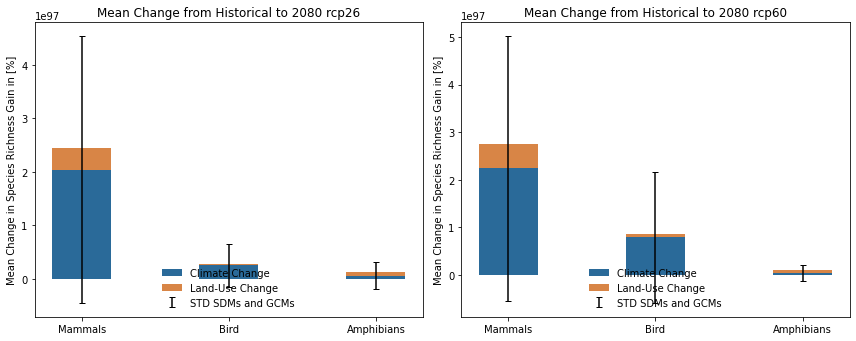

In [22]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                    
                                                    # Avoid division by zero

                
                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / (newvalue_hist_sum_taxa + 1e-100) *100
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / (sum_bin_hist_sum_taxa+ 1e-100)*100
                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_gain
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_gain




fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        # ...
        mean_climate_change = np.mean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.mean([np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Mean Change in Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


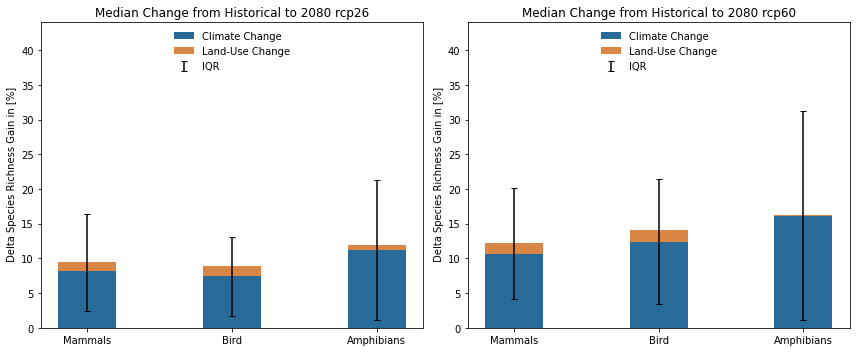

In [60]:
# relative gain, no otliers  in species richness globally
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                    
                                                    # Avoid division by zero

                
                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / (newvalue_hist_sum_taxa + 1e-100) *100 
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / (sum_bin_hist_sum_taxa+ 1e-100)*100
                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_gain
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_gain


cleaned_means = {}

for scenario in scenarios:
    cleaned_means[scenario] = {}
    for sdm in sdms:
        cleaned_means[scenario][sdm] = {}
        for gcm in gcms:
            cleaned_means[scenario][sdm][gcm] = {}
            for taxa in taxas:
                # Combine the data
                combined_data = mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values
                # Apply outlier removal
                cleaned_data = remove_outliers(combined_data)
                # Calculate the mean
                cleaned_means[scenario][sdm][gcm][taxa] = np.nanmean(cleaned_data)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        # ...
        mean_climate_change = np.mean([np.nanmean(remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.mean([cleaned_means[scenario][sdm][gcm][taxa] for sdm in sdms for gcm in gcms])
        
        
        climate_change_data = np.concatenate([mean_newvalue_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])
        land_use_change_data = np.concatenate([cleaned_means[scenario][sdm][gcm][taxa].flatten() for sdm in sdms for gcm in gcms])

        # Calculate the median for the concatenated data
        mean_climate_change = np.nanmedian(climate_change_data)
        mean_land_use_change2 = np.nanmedian(land_use_change_data)
        
        Q1 = np.nanpercentile(climate_change_data, 25)
        Q3 = np.nanpercentile(climate_change_data, 75)
        iqr_climate_change = Q3 - Q1

        std_dev_climate_change = np.std([np.nanmean(remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=iqr_climate_change/2, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'IQR'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change, yerr=iqr_climate_change/2, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel(' Delta Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Median Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


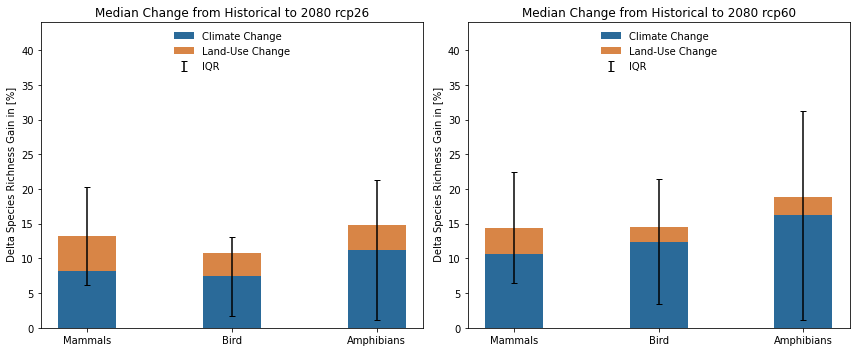

In [87]:
# relative gain, no otliers  in species richness globally
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                    
                                                    # Avoid division by zero

                
                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / (newvalue_hist_sum_taxa + 1e-100) *100 
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / (sum_bin_hist_sum_taxa+ 1e-100)*100
                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_gain
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_gain


cleaned_means = {}



fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        # ...

        
        
        climate_change_data = np.concatenate([mean_newvalue_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])
        land_use_change_data = np.concatenate([mean_sum_bin_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])

        # Calculate the median for the concatenated data
        mean_climate_change = np.nanmedian(climate_change_data)
        mean_land_use_change2 = np.nanmedian(land_use_change_data) -mean_climate_change
        
        Q1 = np.nanpercentile(climate_change_data, 25)
        Q3 = np.nanpercentile(climate_change_data, 75)
        iqr_climate_change = (Q3 - Q1)/2

        std_dev_climate_change = np.std([np.nanmedian(mean_newvalue_change[scenario][sdm][gcm][taxa].values)for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=iqr_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'IQR'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change, yerr=iqr_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel(' Delta Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Median Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [75]:
mean_land_use_change2

-0.028126186042104623

In [68]:
taxa

'Amphibians'

In [69]:
scenario

'rcp60'

In [40]:
std_dev_climate_change

15.818886593902157

In [32]:
def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]

# Process the data to remove outliers and calculate means
cleaned_newvalue_change = {}
cleaned_sum_bin_change = {}

for scenario in scenarios:
    cleaned_newvalue_change[scenario] = {}
    cleaned_sum_bin_change[scenario] = {}

    for sdm in sdms:
        cleaned_newvalue_change[scenario][sdm] = {}
        cleaned_sum_bin_change[scenario][sdm] = {}

        for gcm in gcms:
            cleaned_newvalue_change[scenario][sdm][gcm] = {}
            cleaned_sum_bin_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Remove outliers
                clean_newvalue = remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)
                clean_sum_bin = remove_outliers(mean_sum_bin_change[scenario][sdm][gcm][taxa].values)

                # Calculate mean values
                cleaned_newvalue_change[scenario][sdm][gcm][taxa] = np.nanmean(clean_newvalue)
                cleaned_sum_bin_change[scenario][sdm][gcm][taxa] = np.nanmean(clean_sum_bin)

# Calculate mean_land_use_change2 using the cleaned data
mean_land_use_change2 = {}
for scenario in scenarios:
    mean_land_use_change2[scenario] = np.mean([
        cleaned_sum_bin_change[scenario][sdm][gcm][taxa] - cleaned_newvalue_change[scenario][sdm][gcm][taxa]
        for sdm in sdms for gcm in gcms for taxa in taxas
    ])

TypeError: 'numpy.float64' object does not support item assignment

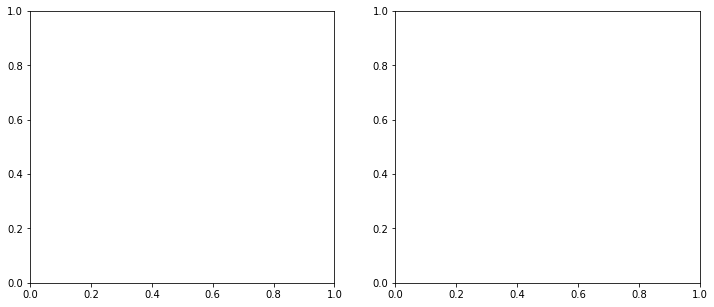

In [36]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        # ...
        
        mean_climate_change = cleaned_newvalue_change[scenario][sdm][gcm][taxa]
        mean_land_use_change2[scenario] = np.mean([
            cleaned_sum_bin_change[scenario][sdm][gcm][taxa] - cleaned_newvalue_change[scenario][sdm][gcm][taxa]
            for sdm in sdms for gcm in gcms for taxa in taxas
        ])


        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Mean Change in Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


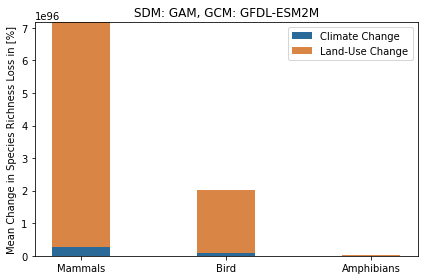

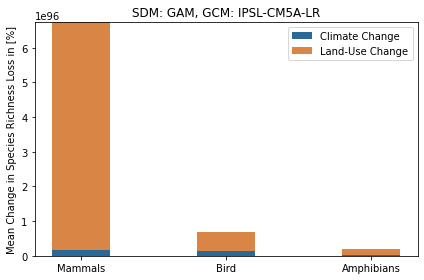

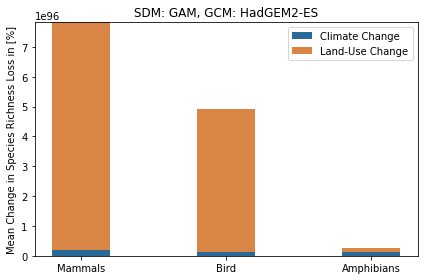

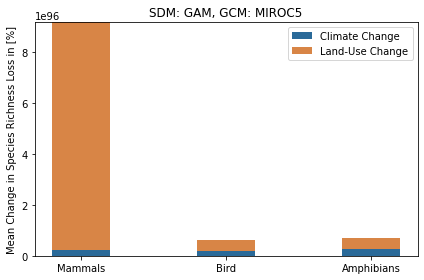

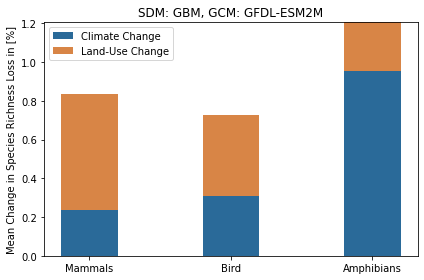

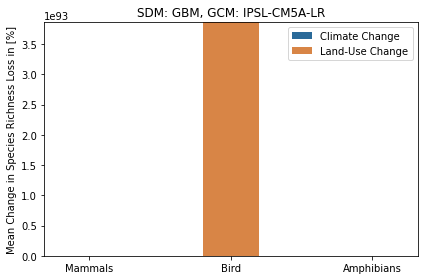

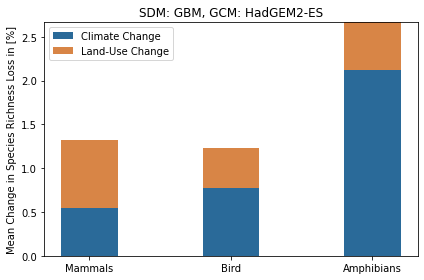

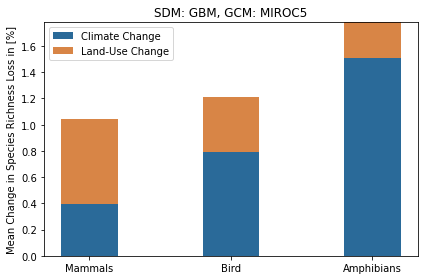

In [16]:
#with outlier 

# Create separate plots for each combination of SDM and GCM
for sdm in sdms:
    for gcm in gcms:
        # Set up the bar plot
        fig, ax = plt.subplots()

        color_change = "#2a6a99"
        color_land_use_change = "#d88546"

        bar_width = 0.4
        error_bar_shift = 0.1

        x_positions = np.arange(len(taxas))

        # Create a variable to store the handles and labels for the legend
        handles, labels = [], []

        for i, taxa in enumerate(taxas):
            x_shift = x_positions[i]

            # Calculate the mean values for the specific combination of SDM and GCM
            mean_climate_change = np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa])
            mean_land_use_change2 = np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa])

            # Calculate standard deviation or confidence interval for climate_change


            if not i:
                handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
                handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

            else:
                ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
                ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)


        # Combine handles and labels for legend
        handles.extend([handle_climate_change, handle_land_use_change])
        labels.extend(['Climate Change', 'Land-Use Change', 'Uncertainty'])

        # Set plot details
        ax.set_xticks(x_positions)
        ax.set_xticklabels(taxas)
        ax.set_ylabel('Mean Change in Species Richness Loss in [%]')
        ax.legend(handles=handles, labels=labels)

        # Set plot title with the combination of SDM and GCM
        ax.set_title(f"SDM: {sdm}, GCM: {gcm}")

        plt.tight_layout()
        plt.show()


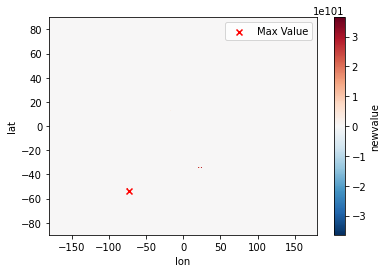

In [34]:
import matplotlib.pyplot as plt

# Assuming gcm and taxa are defined
data_array = mean_newvalue_change["rcp60"]["GAM"][gcm]['Mammals']

# Find the coordinates of the maximum value
max_coords = data_array.where(data_array == data_array.max(), drop=True)

# Replace the maximum value with NaN
data_array_no_max = data_array.where(data_array != data_array.max())

# Plot the modified data
data_array_no_max.plot()

# Mark the location of the maximum value on the map
plt.scatter(max_coords['lon'], max_coords['lat'], color='red', marker='x', label='Max Value')

plt.legend()
plt.show()


In [35]:
data_array_no_max.max()

<xarray.DataArray 'newvalue' ()>
array(3.64228524e+101)

/scratch/local/2685344/ipykernel_7727/133869263.py:102: RuntimeWarning: invalid value encountered in subtract
  combined_data = mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values


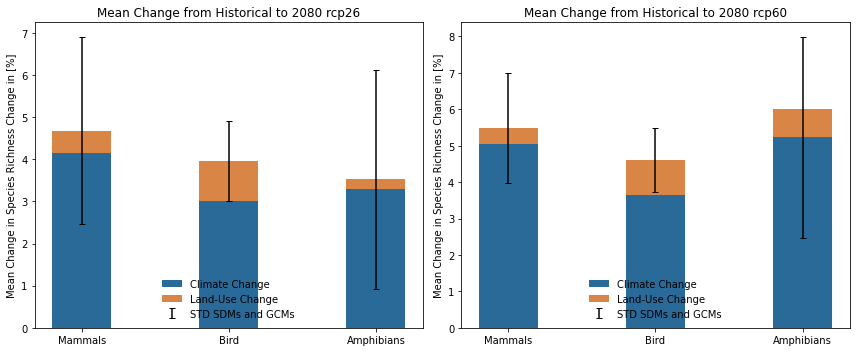

In [4]:
# relative change, no otliers  in species richness globally
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                    
                                                    # Avoid division by zero

                
                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / (newvalue_hist_sum_taxa) *100
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / (sum_bin_hist_sum_taxa) * 100
                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
               # climate_land_change_gain = climate_land_change.where(climate_land_change>0)
               # climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change


cleaned_means = {}

for scenario in scenarios:
    cleaned_means[scenario] = {}
    for sdm in sdms:
        cleaned_means[scenario][sdm] = {}
        for gcm in gcms:
            cleaned_means[scenario][sdm][gcm] = {}
            for taxa in taxas:
                # Combine the data
                combined_data = mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values
                # Apply outlier removal
                cleaned_data = remove_outliers(combined_data)
                # Calculate the mean
                cleaned_means[scenario][sdm][gcm][taxa] = np.nanmean(cleaned_data)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        # ...
        mean_climate_change = np.mean([np.nanmean(remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.mean([cleaned_means[scenario][sdm][gcm][taxa] for sdm in sdms for gcm in gcms])
        

        std_dev_climate_change = np.std([np.nanmean(remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('Mean Change in Species Richness Change in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [15]:
cleaned_means

{'rcp26': {'GAM': {'GFDL-ESM2M': {'Mammals': 0.0,
    'Bird': 0.0,
    'Amphibians': 0.0},
   'IPSL-CM5A-LR': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'HadGEM2-ES': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'MIROC5': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0}},
  'GBM': {'GFDL-ESM2M': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'IPSL-CM5A-LR': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'HadGEM2-ES': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'MIROC5': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0}}},
 'rcp60': {'GAM': {'GFDL-ESM2M': {'Mammals': 0.0,
    'Bird': 0.0,
    'Amphibians': 0.0},
   'IPSL-CM5A-LR': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'HadGEM2-ES': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'MIROC5': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0}},
  'GBM': {'GFDL-ESM2M': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},
   'IPSL-CM5A-LR': {'Mammals': 0.0, 'Bird': 0.0, 'Amphibians': 0.0},


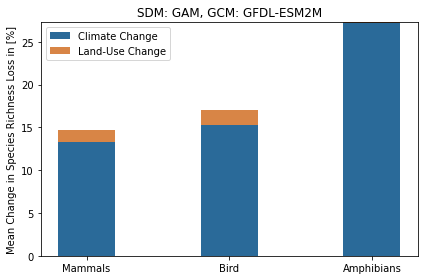

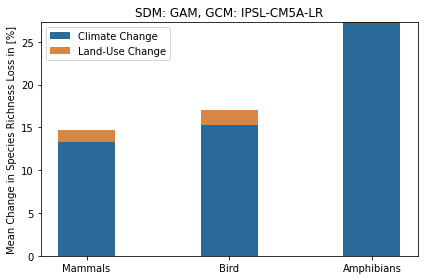

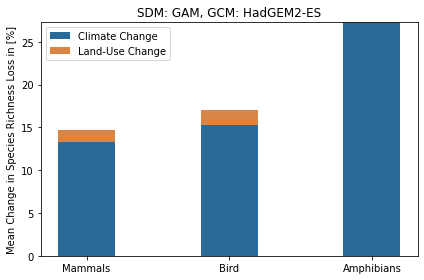

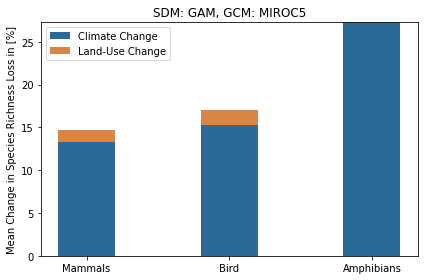

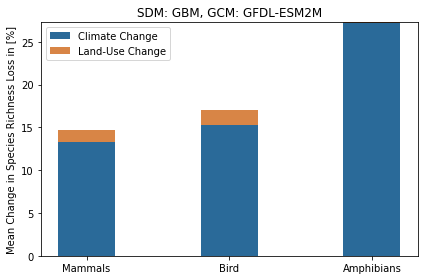

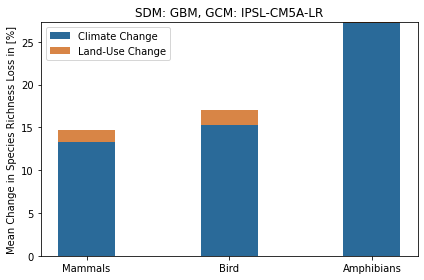

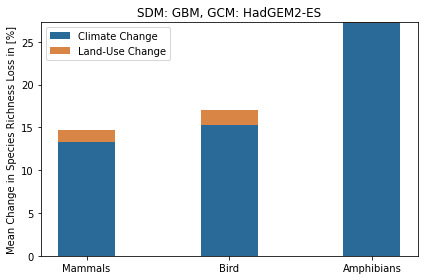

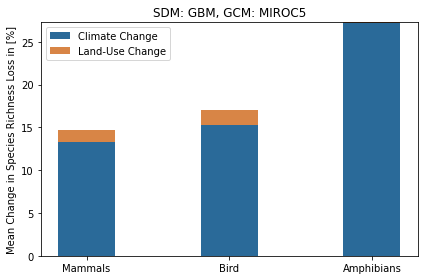

In [48]:
#without outlier 

# Create separate plots for each combination of SDM and GCM
for sdm in sdms:
    for gcm in gcms:
        # Set up the bar plot
        fig, ax = plt.subplots()

        color_change = "#2a6a99"
        color_land_use_change = "#d88546"

        bar_width = 0.4
        error_bar_shift = 0.1

        x_positions = np.arange(len(taxas))

        # Create a variable to store the handles and labels for the legend
        handles, labels = [], []

        for i, taxa in enumerate(taxas):
            x_shift = x_positions[i]

                # Calculate the mean values for the specific combination of SDM and GCM
            mean_climate_change = np.mean([np.nanmean(remove_outliers(mean_newvalue_change[scenario][sdm][gcm][taxa].values)) for sdm in sdms for gcm in gcms])
            mean_land_use_change2 = np.mean([cleaned_means[scenario][sdm][gcm][taxa] for sdm in sdms for gcm in gcms])

            # Calculate standard deviation or confidence interval for climate_change


            if not i:
                handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
                handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

            else:
                ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
                ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)


        # Combine handles and labels for legend
        handles.extend([handle_climate_change, handle_land_use_change])
        labels.extend(['Climate Change', 'Land-Use Change', 'Uncertainty'])

        # Set plot details
        ax.set_xticks(x_positions)
        ax.set_xticklabels(taxas)
        ax.set_ylabel('Mean Change in Species Richness Loss in [%]')
        ax.legend(handles=handles, labels=labels)

        # Set plot title with the combination of SDM and GCM
        ax.set_title(f"SDM: {sdm}, GCM: {gcm}")

        plt.tight_layout()
        plt.show()


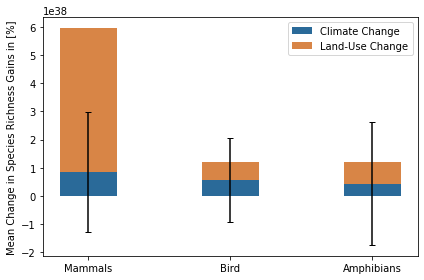

In [33]:
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = [ "GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario=["rcp60"]
time=['65']
# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for sdm in sdms:
    mean_newvalue_change[sdm] = {}
    mean_sum_bin_change[sdm] = {}
    mean_land_use_change[sdm] = {}

    for gcm in gcms:
        mean_newvalue_change[sdm][gcm] = {}
        mean_sum_bin_change[sdm][gcm] = {}
        mean_land_use_change[sdm][gcm] = {}

        for taxa in taxas:
            # Load pickle files
            newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_{scenario}_{time}.pkl")
            newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_{scenario}_{time}.pkl")
            sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_{scenario}_{time}.pkl")
            sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_{scenario}_{time}.pkl")

            with open(newvalue_hist_sum_path, "rb") as f:
                newvalue_hist_sum_taxa = pickle.load(f)

            with open(newvalue_future_sum_path, "rb") as f:
                newvalue_future_sum_taxa = pickle.load(f)

            with open(sum_bin_hist_sum_path, "rb") as f:
                sum_bin_hist_sum_taxa = pickle.load(f)

            with open(sum_bin_future_sum_path, "rb") as f:
                sum_bin_future_sum_taxa = pickle.load(f)

            climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / (newvalue_hist_sum_taxa + 0.00000000000000000000000000000000000000000001)
            climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / (sum_bin_hist_sum_taxa+ 0.00000000000000000000000000000000000000000001)
            land_use_change = climate_land_change - climate_change
            
                            #climate_change_loss = climate_change.where(climate_change < 0)
            climate_land_change_loss = climate_land_change.where(climate_land_change>0)
            climate_change_loss = climate_change.where((climate_land_change > 0) & (climate_change > 0))

            # Store mean changes in dictionaries
            mean_newvalue_change[sdm][gcm][taxa] = climate_land_change_loss
            mean_sum_bin_change[sdm][gcm][taxa] = climate_change_loss
            mean_land_use_change[sdm][gcm][taxa] = land_use_change
            
# Set up the bar plot
fig, ax = plt.subplots()

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for i, taxa in enumerate(taxas):
    x_shift = x_positions[i]

    # Calculate the mean values over all SDMs and GCMs
    mean_climate_change = np.mean([np.mean(mean_newvalue_change[sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
    mean_land_use_change2 = np.mean([np.mean(mean_sum_bin_change[sdm][gcm][taxa] - mean_newvalue_change[sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

    # Calculate standard deviation or confidence interval for climate_change
    range_climate_change = np.ptp([mean_newvalue_change[sdm][gcm][taxa].mean() for sdm in sdms for gcm in gcms])

    # Calculate standard deviation or confidence interval for land_use_change
  

    if not i:
        handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
        handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
        ax.errorbar(x_shift, mean_climate_change, yerr=range_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')



    else:
        ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
        ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
        ax.errorbar(x_shift, mean_climate_change, yerr=range_climate_change, fmt='none', capsize=3, color='black')
      

# Combine handles and labels for legend
handles.extend([handle_climate_change, handle_land_use_change])
labels.extend(['Climate Change', 'Land-Use Change', 'Uncertainty'])

# Set plot detailsax.set_ylim(bottom=0, top=np.max(mean_climate_change) + 2 * std_dev_climate_change)
ax.set_xticks(x_positions)
ax.set_xticklabels(taxas)
ax.set_ylabel('Mean Change in Species Richness Gains in [%]')
ax.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()



In [31]:
climate_change.mean()

<xarray.DataArray 'newvalue' ()>
array(inf)

Taxa: Bird
Scenario: rcp26, SDM: GAM, GCM: GFDL-ESM2M, Mean Data: 14.171950166871166
Scenario: rcp26, SDM: GAM, GCM: IPSL-CM5A-LR, Mean Data: 11.087272917785162
Scenario: rcp26, SDM: GAM, GCM: HadGEM2-ES, Mean Data: 14.727144661283837
Scenario: rcp26, SDM: GAM, GCM: MIROC5, Mean Data: 15.179449232091008
Scenario: rcp26, SDM: GBM, GCM: GFDL-ESM2M, Mean Data: 7.635684244557419
Scenario: rcp26, SDM: GBM, GCM: IPSL-CM5A-LR, Mean Data: 7.016827302439354
Scenario: rcp26, SDM: GBM, GCM: HadGEM2-ES, Mean Data: 8.87025906303258
Scenario: rcp26, SDM: GBM, GCM: MIROC5, Mean Data: 9.449734437101856
Scenario: rcp60, SDM: GAM, GCM: GFDL-ESM2M, Mean Data: 21.49623836270294
Scenario: rcp60, SDM: GAM, GCM: IPSL-CM5A-LR, Mean Data: 17.11469413639145
Scenario: rcp60, SDM: GAM, GCM: HadGEM2-ES, Mean Data: 28.904614772970895
Scenario: rcp60, SDM: GAM, GCM: MIROC5, Mean Data: 23.61608546314318
Scenario: rcp60, SDM: GBM, GCM: GFDL-ESM2M, Mean Data: 11.895012664149629
Scenario: rcp60, SDM: GBM, GCM: IPSL-CM5A

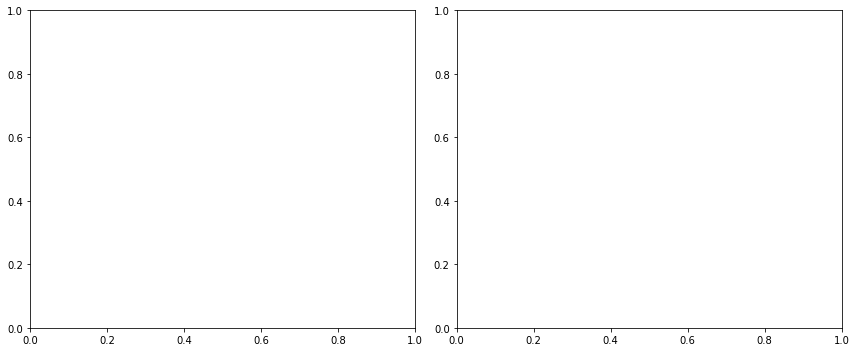

In [156]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for taxa in taxas:
    print(f"Taxa: {taxa}")
    for scenario in scenarios:
        for sdm in sdms:
            for gcm in gcms:
                print(f"Scenario: {scenario}, SDM: {sdm}, GCM: {gcm}, Mean Data: {np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa])}")
mean_data = {}
mean_land_use_change2_data = {}
         
                
for taxa in taxas:
    mean_data[taxa] = []
    mean_land_use_change2_data[taxa] = []

    print(f"Taxa: {taxa}")
    for scenario in scenarios:
        for sdm in sdms:
            for gcm in gcms:
                mean_climate_change = np.mean([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
                mean_land_use_change2 = np.mean([np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

                print(f"Scenario: {scenario}, SDM: {sdm}, GCM: {gcm}, Mean Data: {mean_val}, Mean Land Use Change 2: {mean_land_use_change2_val}")

                mean_data[taxa].append(mean_val)
                mean_land_use_change2_data[taxa].append(mean_land_use_change2_val)


        # Take the mean over both SDMs and GCMs for each taxa and scenario
        mean_climate_change = np.nanmean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.nanmean([np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change])
            scenario_labels.extend(['Climate Change', 'Land-Use Change'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)



# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


Taxa: Mammals
Scenario: rcp26, SDM: GAM, GCM: GFDL-ESM2M, Mean Data: 30888890.604563553, Mean Land Use Change 2: 14429214.301313091
Scenario: rcp26, SDM: GAM, GCM: IPSL-CM5A-LR, Mean Data: 15444447.382598963, Mean Land Use Change 2: 7214606.219401335
Scenario: rcp26, SDM: GAM, GCM: HadGEM2-ES, Mean Data: 263327760.2140005, Mean Land Use Change 2: 123009067.19202062
Scenario: rcp26, SDM: GAM, GCM: MIROC5, Mean Data: 3.385038798724161, Mean Land Use Change 2: -1.3661662684819327
Scenario: rcp26, SDM: GBM, GCM: GFDL-ESM2M, Mean Data: 0.5464478320296074, Mean Land Use Change 2: 0.7900493333638323
Scenario: rcp26, SDM: GBM, GCM: IPSL-CM5A-LR, Mean Data: 0.26418541506273685, Mean Land Use Change 2: 0.7156955734145616
Scenario: rcp26, SDM: GBM, GCM: HadGEM2-ES, Mean Data: 0.7669394335473196, Mean Land Use Change 2: 0.7462440051172855
Scenario: rcp26, SDM: GBM, GCM: MIROC5, Mean Data: 0.6170588022588005, Mean Land Use Change 2: 0.776460073301053


ValueError: shape mismatch: objects cannot be broadcast to a single shape

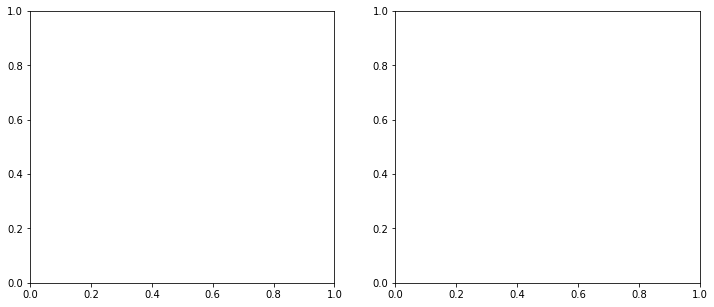

In [134]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for i, taxa in enumerate(taxas):
    mean_data[taxa] = []
    mean_land_use_change2_data[taxa] = []

    print(f"Taxa: {taxa}")
    
    scenario_handles, scenario_labels = [], []

    for scenario in scenarios:
        x_shift = x_positions + i * (bar_width + error_bar_shift)

        mean_climate_change = []
        mean_land_use_change2 = []

        for sdm in sdms:
            for gcm in gcms:
                mean_val = np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa])
                mean_land_use_change2_val = np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa])

                print(f"Scenario: {scenario}, SDM: {sdm}, GCM: {gcm}, Mean Data: {mean_val}, Mean Land Use Change 2: {mean_land_use_change2_val}")

                mean_climate_change.append(mean_val)
                mean_land_use_change2.append(mean_land_use_change2_val)

        if not i:
            handle_climate_change = axes[0].bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = axes[0].bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change])
            scenario_labels.extend(['Climate Change', 'Land-Use Change'])

        else:
            axes[0].bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            axes[0].bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)

# Set the final legend outside the loop
fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [14]:
data_array_no_max

<xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [15]:
data_array_no_max.max()

<xarray.DataArray 'newvalue' ()>
array(98.43157782)

In [ ]:
# Print values used in the calculation
print(mean_newvalue_change[scenario][sdm][gcm][taxa])

# Calculate mean with NaN values excluded
mean_climate_change = np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa])
print(f"Mean Climate Change: {mean_climate_change}")


In [ ]:
# Assuming your DataArray is named "climate_change"
mean_climate_change = np.nanmean(climate_change)


In [ ]:
mean_climate_change